# Testing Stock Fetcher 

## Imports 

In [1]:
# Reload Custom Modules 
import importlib
import src.beta_vae
import src.data_fetching 
import src.portfolio
importlib.reload(src.beta_vae)
importlib.reload(src.data_fetching)
importlib.reload(src.portfolio)

<module 'src.portfolio' from 'c:\\Users\\jairp\\OneDrive\\Desktop_remote\\HEC Montreal\\4. Fall 2024\\Deep Learning II\\Project\\StockDiversifier\\src\\portfolio.py'>

In [2]:
# General 
import os 
import json 
import random 
from tqdm.notebook import tqdm

# Data Science
import optuna 
import numpy as np 
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# PyTorch
import torch

# Custom Classes 
from src.beta_vae import Encoder
from src.beta_vae import Decoder
from src.beta_vae import BetaVAE
from src.portfolio import Portfolio

# Custom Functions
from src.beta_vae import create_data_loaders
from src.beta_vae import create_single_data_loader
from src.beta_vae import objective
from src.beta_vae import train_beta_vae
from src.beta_vae import get_embeddings
from src.beta_vae import generate_embeddings_dict
from src.portfolio import fetch_and_calculate_returns
from src.portfolio import diversify_betavae_portfolio
from src.data_fetching import scrape_sp500_wikipedia
from src.data_fetching import fetch_stock_data
from src.data_fetching import prepare_data_for_vae

In [3]:
custom_tickers = [
    'PLTR',  # Palantir Technologies Inc. (Technology)
    'COIN',  # Coinbase Global, Inc. (Financials)
    'WDAY',  # Workday, Inc. (Technology)
    'TTD',   # The Trade Desk, Inc. (Technology)
    'APO',   # Apollo Global Management, Inc. (Financials)
    'MELI',  # MercadoLibre, Inc. (Consumer Discretionary)
    'NVO',   # Novo Nordisk A/S (Healthcare)
    'ICON',  # Icon PLC (Healthcare)
    'TSM',   # Taiwan Semiconductor Manufacturing Company Limited (Technology)
    'SKX',   # Skechers U.S.A., Inc. (Consumer Discretionary)
    'BAYRY', # Bayer AG (Healthcare)
    'DISCK', # Discovery, Inc. (Communication Services)
    'FNV',   # Franco-Nevada Corporation (Materials)
    'SHOP',  # Shopify Inc. (Technology)
    'SQ',    # Square, Inc. (Technology)
    'UBER',  # Uber Technologies, Inc. (Industrials)
    'ZM',    # Zoom Video Communications, Inc. (Technology)
    'TWLO',  # Twilio Inc. (Technology)
    'MRNA',  # Moderna, Inc. (Healthcare)
    'WDAY',  # Workday, Inc. (Technology)
    'DOCU',  # DocuSign, Inc. (Technology)
    'VEEV',  # Veeva Systems Inc. (Healthcare)
    'LULU',  # Lululemon Athletica Inc. (Consumer Discretionary)
    'ROKU',  # Roku, Inc. (Communication Services)
    'CRWD',  # CrowdStrike Holdings, Inc. (Technology)
    'SNOW',  # Snowflake Inc. (Technology)
    'NET',   # Cloudflare, Inc. (Technology)
    'PINS',  # Pinterest, Inc. (Communication Services)
    'ETSY',  # Etsy, Inc. (Consumer Discretionary)
    'SPOT',   # Spotify Technology S.A. (Communication Services)
    "AAPL", # Apple Inc. (Technology)
]

## Fetching the data 

In [4]:
# Convert ndarray values to lists for JSON serialization
def serialize_ndarray(data_dict):
    return {key: (value.tolist() if isinstance(value, np.ndarray) else value) for key, value in data_dict.items()}

# Convert lists back to ndarrays if needed
def deserialize_ndarray(data_dict):
    return {key: (np.array(value) if isinstance(value, list) else value) for key, value in data_dict.items()}

In [5]:
# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

# extract the tickers from the dataframe
sp500_tickers = sp500_df["Symbol"].tolist()

# check for tikers with anomalies 
anomalies = [ticker for ticker in sp500_tickers if not ticker.isalnum()]
print(anomalies)

# check if apple is in the tickers
print("AAPL" in sp500_tickers)

# show the first couple of columns 
print(sp500_df.head())

['BRK.B', 'BF.B']
True
  Symbol             Security             GICS Sector
0    MMM                   3M             Industrials
1    AOS          A. O. Smith             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV               AbbVie             Health Care
4    ACN            Accenture  Information Technology


In [ ]:
REFETCH = True 
LOAD_RETURNS = False 

############################################################################################
### Step 1: Scrape SP500

# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

############################################################################################
## Step 2: Fetch Stock Data Features

if REFETCH:
    # Fetch data for all sp500 + custom tickers
    stock_data, sector_mapping, industry_mapping = fetch_stock_data(sp500_df, custom_tickers, 
                                                                    period = "1y", interval = "1wk",
                                                                    savepath="data_raw/stock_data.csv") # Fetch data
else: 
    # read data from file
    stock_data = pd.read_csv("data_raw/stock_data.csv", index_col=0).reset_index()

Fetching stock data...:  10%|▉         | 51/527 [01:14<11:20,  1.43s/it]SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  15%|█▌        | 80/527 [01:54<10:49,  1.45s/it]AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
AMTM: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
Fetching stock data...:  43%|████▎     | 226/527 [05:23<07:26,  1.48s/it]ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  58%|█████▊    | 308/527 [07:20<05:34,  1.53s/it]$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$DISCK: possibly delisted; no price data found  (perio

Completed fetching stock data in 766.38 seconds.
saving data to data_raw/stock_data.csv


In [7]:
############################################################################################
## Step 3: Fetch Returns for all tickers

if LOAD_RETURNS:
    # Load the returns from the file
    with open("data_raw/all_returns.json", "r") as f:
        all_returns = json.load(f)

    # Deserialize loaded data
    all_returns = deserialize_ndarray(all_returns)

    # Show the first few tickers and their returns
    print("First few tickers and their returns:")
    for ticker, returns in list(all_returns.items())[:5]:
        print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

else: 
    # Fetch and calculate returns for the all tickers in the S&P 500 and additional tickers
    all_tickers = stock_data["Ticker"].values.tolist()  # All S&P 500 tickers
    print(f"number of tickers: {len(all_tickers)}")

    # Fetch and calculate returns for all tickers
    all_returns = fetch_and_calculate_returns(all_tickers, period="1y", interval="1wk", price_column="Close")

    # Find the mode of the lengths of the returns among all tickers
    return_lengths = [len(returns) for returns in all_returns.values()]
    return_length_mode = max(set(return_lengths), key=return_lengths.count)
    
    # Ensure to keep only the returns with the mode length and report the discarded tickers 
    discarded_tickers = [ticker for ticker, returns in all_returns.items() if len(returns) != return_length_mode]
    all_returns = {ticker: returns for ticker, returns in all_returns.items() if len(returns) == return_length_mode}
    print(f"Discarded tickers with inconsistent return lengths: {discarded_tickers}")

    # Remove from stock_data the tickers with inconsistent return lengths
    stock_data = stock_data[stock_data["Ticker"].isin(all_returns.keys())].reset_index().drop(columns=["index"])

    print("Total number of tickers with consistent return lengths:", len(all_returns))
    print("stock_date shape:", stock_data.shape)

    # Save the dictionary with the returns to a file using json 
    with open("data_raw/all_returns.json", "w") as f:
        print(f"Saving returns to {f.name}")
        json.dump(serialize_ndarray(all_returns), f, indent=4)

############################################################################################
## Step 4: Prepare Data for VAE	

# Prepare data for VAE
stock_data_vae = prepare_data_for_vae(stock_data) 

number of tickers: 523


Fetching Data: 100%|██████████| 523/523 [10:12<00:00,  1.17s/ticker]


Discarded tickers with inconsistent return lengths: ['SOLV', 'GEV']
Total number of tickers with consistent return lengths: 521
stock_date shape: (521, 18)
Saving returns to data_raw/all_returns.json


In [8]:
# Show one example return series
print("Returns for AAPL:")
print(all_returns["AAPL"])

Returns for AAPL:
[ 0.02337379  0.00950388 -0.0200941  -0.00552697 -0.05895191  0.0261619
  0.03033562  0.00448952 -0.03414402  0.01614201 -0.03339895  0.00115197
 -0.01566941 -0.04970512  0.01107016 -0.00196965 -0.00464362 -0.01107997
  0.04110154 -0.06542058  0.02606062  0.08316588 -0.00179947  0.0386644
  0.00057937  0.01194859  0.02413527  0.07923211 -0.02353049  0.01508496
  0.0746368   0.01855617 -0.02702351 -0.02830899  0.00871721 -0.01646498
  0.04536618  0.00465631  0.00952219 -0.0357205   0.00760797  0.02561793
 -0.00179665 -0.00434609  0.00330688  0.03274001 -0.01527655 -0.03673136
  0.01816883 -0.00754524  0.02164442  0.02053335]


In [9]:
stock_data.head()

,Ticker,Company Name,Market Cap,Sector,Industry,Open Price,Close Price,High Price,Low Price,Last Close,52 Week High,52 Week Low,Last Month Volatility,52 Week Volatility,Yearly Dividend Rate,Last Year Return Rate,Sector_encoded,Industry_encoded
0,MCD,McDonald's Corporation,2.135743e+11,Consumer Discretionary,Restaurants,279.266249,279.578264,317.899994,242.121090,298.029999,317.899994,242.121098,0.201884,0.179217,7.08,0.083044,0,0
1,TFX,Teleflex Incorporated,8.949237e+09,Health Care,Medical Instruments & Supplies,225.823493,225.348953,256.204721,185.660004,192.690002,256.204700,185.660004,0.260435,0.296542,1.36,-0.113880,1,1
2,RMD,ResMed Inc.,3.672029e+10,Health Care,Medical Instruments & Supplies,204.224658,206.447153,259.927933,150.544765,250.145004,259.927933,150.544764,0.370611,0.371925,2.12,0.654847,1,1
3,MPWR,"Monolithic Power Systems, Inc.",2.691290e+10,Information Technology,Semiconductors,738.155087,740.638109,958.343224,534.597368,551.719971,958.343217,534.597333,0.524647,0.537039,5.00,0.015940,2,2
4,NDAQ,"Nasdaq, Inc.",4.781124e+10,Financials,Financial Data & Stock Exchanges,63.386704,63.869502,83.500000,52.821068,83.184998,83.500000,53.029997,0.187514,0.190101,0.96,0.531433,3,3


In [10]:
# Display the data 
print(stock_data_vae.head())

     Market Cap  Open Price  Close Price  High Price   Low Price  Last Close  \
0  2.135743e+11  279.266249   279.578264  317.899994  242.121090  298.029999   
1  8.949237e+09  225.823493   225.348953  256.204721  185.660004  192.690002   
2  3.672029e+10  204.224658   206.447153  259.927933  150.544765  250.145004   
3  2.691290e+10  738.155087   740.638109  958.343224  534.597368  551.719971   
4  4.781124e+10   63.386704    63.869502   83.500000   52.821068   83.184998   

   52 Week High  52 Week Low  Last Month Volatility  52 Week Volatility  ...  \
0    317.899994   242.121098               0.201884            0.179217  ...   
1    256.204700   185.660004               0.260435            0.296542  ...   
2    259.927933   150.544764               0.370611            0.371925  ...   
3    958.343217   534.597333               0.524647            0.537039  ...   
4     83.500000    53.029997               0.187514            0.190101  ...   

   Industry_Tools & Accessories  Indus

In [11]:
# Print number of columns for stock_data 
print(len(stock_data.columns))

# Print number of columns in total 
print(len(stock_data_vae.columns))

# Print total number of rows 
print(len(stock_data_vae))

# Print the data types of the columns
print(stock_data_vae.dtypes)

18
145
521
Market Cap                                 float64
Open Price                                 float64
Close Price                                float64
High Price                                 float64
Low Price                                  float64
                                            ...   
Industry_Utilities - Regulated Electric    float64
Industry_Utilities - Regulated Gas         float64
Industry_Utilities - Regulated Water       float64
Industry_Utilities - Renewable             float64
Industry_Waste Management                  float64
Length: 145, dtype: object


In [12]:
print(stock_data_vae.columns)

Index(['Market Cap', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Last Close', '52 Week High', '52 Week Low', 'Last Month Volatility',
       '52 Week Volatility',
       ...
       'Industry_Tools & Accessories', 'Industry_Travel Services',
       'Industry_Trucking', 'Industry_Utilities - Diversified',
       'Industry_Utilities - Independent Power Producers',
       'Industry_Utilities - Regulated Electric',
       'Industry_Utilities - Regulated Gas',
       'Industry_Utilities - Regulated Water',
       'Industry_Utilities - Renewable', 'Industry_Waste Management'],
      dtype='object', length=145)


### Check for any NA's

In [13]:
# Check if any columns have nas
print(stock_data_vae.isna().sum().sum())

# Produce a list of columns with nas, and the amount for each 
print(stock_data_vae.columns[stock_data_vae.isna().any()].tolist())

# Calculate the proportion of nas in the stock_data_vae dataframe for each column with nas 
# only for the columns with nas
nas_proportion = stock_data_vae.isna().mean()
print(nas_proportion[stock_data_vae.columns[stock_data_vae.isna().any()].tolist()])

0
[]
Series([], dtype: float64)


## Fitting the $\beta$-VAE

### Data Preparation

In [14]:
# Normalize the stock data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(stock_data_vae)

# Convert the normalized data to PyTorch tensors
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(tensor_data)

# Check the DataLoader output
next(iter(train_loader))[0].shape  # Shape of one batch of data

torch.Size([64, 145])

### Hyperparameter Tunning

In [15]:
# Define the file path for storing the best parameters
best_params_file = "config/best_params.json"

REWRITE = True 
if REWRITE:
    # Delete previous best_params file
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

# Check if the best_params file exists
if os.path.exists(best_params_file):
    # Load the best parameters from the file
    with open(best_params_file, "r") as f:
        best_params = json.load(f)
    print("Loaded best parameters from file:", best_params)
    
else:
    # Delete previous best_params file if exists
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

    # File doesn't exist, run the Optuna study
    print("Best parameters file not found. Running Optuna study...")
    
    # Assuming `normalized_data` is the prepared dataset
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, normalized_data, verbose=False), n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters found:", best_params)

    # Save the best parameters to a JSON file
    os.makedirs(os.path.dirname(best_params_file), exist_ok=True)  # Create directory if it doesn't exist
    with open(best_params_file, "w") as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {best_params_file}")

[I 2024-11-27 12:39:34,944] A new study created in memory with name: no-name-78a22d67-7f7e-4b64-a8a4-93bec5aee8a2


Best parameters file not found. Running Optuna study...


[I 2024-11-27 12:39:43,446] Trial 0 finished with value: 141.94337681361608 and parameters: {'latent_dim': 5, 'beta': 5.839537184515756, 'learning_rate': 0.00011929994455071695, 'batch_size': 64}. Best is trial 0 with value: 141.94337681361608.
[I 2024-11-27 12:39:44,571] Trial 1 finished with value: 133.41893726390796 and parameters: {'latent_dim': 5, 'beta': 3.392331139499503, 'learning_rate': 0.00044099183464037245, 'batch_size': 64}. Best is trial 1 with value: 133.41893726390796.
[I 2024-11-27 12:39:45,569] Trial 2 finished with value: 148.17217548076923 and parameters: {'latent_dim': 10, 'beta': 4.905063518894052, 'learning_rate': 0.00019288810312682387, 'batch_size': 128}. Best is trial 1 with value: 133.41893726390796.
[I 2024-11-27 12:39:48,694] Trial 3 finished with value: 133.3490271935096 and parameters: {'latent_dim': 10, 'beta': 8.143263130212851, 'learning_rate': 0.00966474821556992, 'batch_size': 32}. Best is trial 3 with value: 133.3490271935096.
[I 2024-11-27 12:39:49

Best hyperparameters found: {'latent_dim': 10, 'beta': 9.491841779299476, 'learning_rate': 0.0008354710381316489, 'batch_size': 32}
Best parameters saved to config/best_params.json


### Model Training

In [16]:

# File path for the saved model
model_path = "models/beta_vae_with_metadata.pth"

RETRAIN = True
if RETRAIN:
    # Delete previous model file
    if os.path.exists(model_path):
        os.remove(model_path)

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Model found at {model_path}. Loading the model...")

    # Load model state and metadata
    model_metadata = torch.load(model_path)

    # Recreate the model using the saved metadata
    beta_vae = BetaVAE(
        input_dim=model_metadata["input_dim"],
        latent_dim=model_metadata["latent_dim"],
        beta=model_metadata["beta"]
    )
    beta_vae.load_state_dict(model_metadata["model_state"])
    beta_vae.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model not found at {model_path}. Training a new model...")

    # Assuming you use the best hyperparameters from Optuna
    latent_dim = best_params['latent_dim']
    beta = best_params['beta']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    input_dim = stock_data_vae.shape[1]

    # Recreate DataLoaders with the best batch size
    train_loader, val_loader, test_loader = create_data_loaders(tensor_data, batch_size=batch_size)

    # Initialize and train the model
    beta_vae = BetaVAE(input_dim=input_dim, latent_dim=latent_dim, beta=beta)
    train_beta_vae(beta_vae, train_loader, val_loader, num_epochs=50, learning_rate=learning_rate)

    # Save the trained model with metadata
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Ensure the directory exists
    model_metadata = {
        "model_state": beta_vae.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "beta": beta
    }
    torch.save(model_metadata, model_path)
    print(f"Model trained and saved to {model_path}.")

Model not found at models/beta_vae_with_metadata.pth. Training a new model...
Epoch [1/50], Training Loss: 155.0778
Epoch [1/50], Validation Loss: 153.0204
Epoch [2/50], Training Loss: 134.8728
Epoch [2/50], Validation Loss: 148.7965
Epoch [3/50], Training Loss: 133.3992
Epoch [3/50], Validation Loss: 148.6810
Epoch [4/50], Training Loss: 133.3494
Epoch [4/50], Validation Loss: 148.6591
Epoch [5/50], Training Loss: 133.3410
Epoch [5/50], Validation Loss: 148.6677
Epoch [6/50], Training Loss: 133.3367
Epoch [6/50], Validation Loss: 148.6755
Epoch [7/50], Training Loss: 133.3496
Epoch [7/50], Validation Loss: 148.6558
Epoch [8/50], Training Loss: 133.3390
Epoch [8/50], Validation Loss: 148.6604
Epoch [9/50], Training Loss: 133.3363
Epoch [9/50], Validation Loss: 148.6664
Epoch [10/50], Training Loss: 133.3403
Epoch [10/50], Validation Loss: 148.6692
Epoch [11/50], Training Loss: 133.3471
Epoch [11/50], Validation Loss: 148.6672
Epoch [12/50], Training Loss: 133.3427
Epoch [12/50], Valida

### Extract Embeddings for Train/Val/Test Data 

In [17]:
# Extract embeddings for the training data
train_embeddings = get_embeddings(beta_vae, train_loader)

# Optionally, extract embeddings for validation and test data
val_embeddings = get_embeddings(beta_vae, val_loader)
test_embeddings = get_embeddings(beta_vae, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)  # Should be (num_samples, latent_dim)
print("Val Embeddings Shape:", val_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)
print("Total number of embeddings:", train_embeddings.shape[0] + val_embeddings.shape[0] + test_embeddings.shape[0])

Train Embeddings Shape: torch.Size([364, 10])
Val Embeddings Shape: torch.Size([78, 10])
Test Embeddings Shape: torch.Size([79, 10])
Total number of embeddings: 521


### Extract Embeddings from the Stock Data 

In [18]:
# Generate embeddings for the stock data
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Display the embeddings for the first stock
print(f"Embeddings for the first stock ({stock_data['Ticker'].iloc[0]}):")
print(stock_embeddings[stock_data["Ticker"].iloc[0]])

Embeddings for the first stock (MCD):
[-0.8637167   2.4697669  -1.6324048   0.7830798  -0.56319267 -0.11106579
 -0.704044   -0.09831755  2.1452146   0.4785328 ]


### Building the Recommendation Function 

#### Building the Portfolio

Portfolio Summary:
Tickers: ['MTCH', 'CTAS', 'A', 'SBUX', 'CCL', 'AES', 'NFLX', 'TGT', 'EOG', 'MCHP', 'AMGN', 'SRE', 'CF', 'CPT', 'ANET', 'NET', 'KLAC', 'ED', 'TWLO', 'MAS']
Weights: {'MTCH': 0.05, 'CTAS': 0.05, 'A': 0.05, 'SBUX': 0.05, 'CCL': 0.05, 'AES': 0.05, 'NFLX': 0.05, 'TGT': 0.05, 'EOG': 0.05, 'MCHP': 0.05, 'AMGN': 0.05, 'SRE': 0.05, 'CF': 0.05, 'CPT': 0.05, 'ANET': 0.05, 'NET': 0.05, 'KLAC': 0.05, 'ED': 0.05, 'TWLO': 0.05, 'MAS': 0.05}
Portfolio Expected Return: 0.004859987591403466
Portfolio Volatility: 0.019426085209048375
Portfolio Diversification Ratio: 2.2708681593275046
Portfolio Sharpe Ratio: 0.2501784347748952


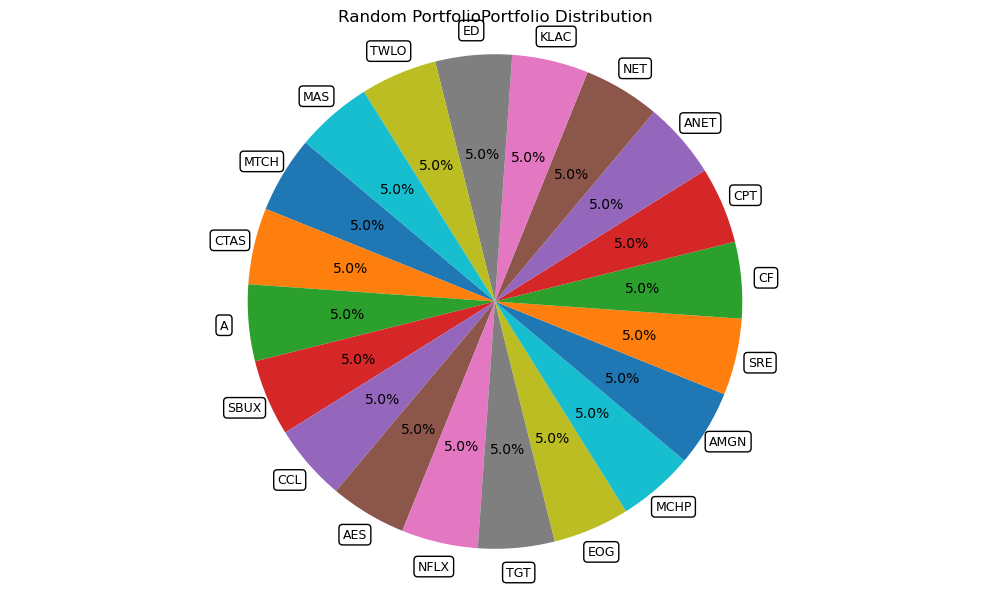

In [19]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Obtain a summary of the portfolio 
random_portfolio.summarize_portfolio()

# Visualize portfolio distribution 
random_portfolio.visualize_portfolio_distribution(pname="Random Portfolio")


#### Optimizing the Portfolio 


--- Portfolio Summary After Optimization ---
Portfolio Summary:
Tickers: ['MTCH', 'CTAS', 'A', 'SBUX', 'CCL', 'AES', 'NFLX', 'TGT', 'EOG', 'MCHP', 'AMGN', 'SRE', 'CF', 'CPT', 'ANET', 'NET', 'KLAC', 'ED', 'TWLO', 'MAS']
Weights: {'MTCH': 0.05550496055630594, 'CTAS': 0.0, 'A': 0.0, 'SBUX': 0.029072258126230023, 'CCL': 0.03773077422601894, 'AES': 0.0, 'NFLX': 0.09805214555262567, 'TGT': 0.08569641452795296, 'EOG': 0.04382618252751954, 'MCHP': 0.0, 'AMGN': 0.04729412199486999, 'SRE': 2.0723719845760526e-17, 'CF': 0.05708398726796988, 'CPT': 0.012724639666433992, 'ANET': 0.0, 'NET': 0.04415115258421833, 'KLAC': 0.060829763012477826, 'ED': 0.3789025520930789, 'TWLO': 0.04913104786430355, 'MAS': 0.0}
Portfolio Expected Return: 0.004551888253928091
Portfolio Volatility: 0.012976947991797494
Portfolio Diversification Ratio: 2.916496668236315
Portfolio Sharpe Ratio: 0.3507672417894609


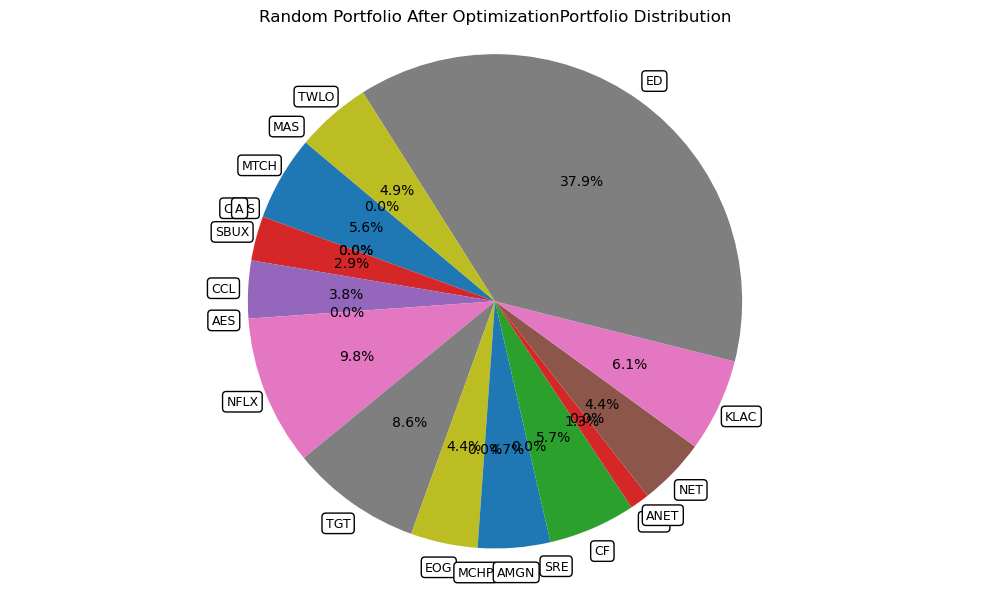

In [20]:
# Optimize portfolio weights 
random_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the portfolio after optimization
print("\n--- Portfolio Summary After Optimization ---")
random_portfolio.summarize_portfolio()

# Visualize the portfolio distribution after optimization
random_portfolio.visualize_portfolio_distribution(pname="Random Portfolio After Optimization")

#### Extracting Portfolio Embeddings

In [21]:
# Define Optim method for both portfolios 
optim_method = "max_div"

# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 15, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Optimize portfolio weights 
random_portfolio.optimize_weights(method=optim_method, update_weights=True)

# Generate embeddings for the stock data (full universe of data)
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Extract embeddings from Portfolio  
random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                               if ticker in stock_embeddings.keys()}

# Check that number of extracted embeddings == number of portfolio tickers
assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)

# Apply the diversify function to the random portfolio
updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
    portfolio = random_portfolio,
    portfolio_embeddings = random_portfolio_embeddings,
    all_returns = all_returns,
    all_stock_embeddings = stock_embeddings,
    num_iter=200, # number of iterations for the optimization algorithm
    top_N=5, # num top most dissimilar assets to consider for swapping
    optim_algorithm=optim_method,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio.diversification_ratio)
print("Diversification History:", diversification_history)
print("Swap Log (Removed -> Added):", swap_log)


Initial Diversification Ratio: 2.7127873714408186


Diversification Iterations: 100%|██████████| 200/200 [00:10<00:00, 19.43it/s]


Final Diversification Ratio: 2.7127873714408186
Diversification History: [2.7127873714408186]
Swap Log (Removed -> Added): {}


In [22]:
print("\n--- Original Portfolio ---")
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

print("\n--- Updated Portfolio ---")

# Optimize the updated portfolio weights with max_div 
updated_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio.summarize_portfolio()


--- Original Portfolio ---
Portfolio Summary:
Tickers: ['MKTX', 'WMT', 'ROP', 'ALB', 'SHOP', 'CHTR', 'BG', 'IFF', 'PLTR', 'HPQ', 'HAS', 'KVUE', 'ROK', 'BLDR', 'TER']
Weights: {'MKTX': 0.168060597100875, 'WMT': 0.1598246236271455, 'ROP': 0.014368233609902201, 'ALB': 0.009409226235432099, 'SHOP': 0.07154100844118894, 'CHTR': 0.0715410196298803, 'BG': 0.15515926636357028, 'IFF': 0.19738047642710715, 'PLTR': 0.048894471436118116, 'HPQ': 0.00019594084486542716, 'HAS': 0.05540194877944461, 'KVUE': 0.03611094472232374, 'ROK': 7.021527302703088e-16, 'BLDR': 0.012112242782146341, 'TER': 3.876026409224968e-17}
Portfolio Expected Return: 0.005556273177831998
Portfolio Volatility: 0.015515921724967324
Portfolio Diversification Ratio: 2.7127872456932405
Portfolio Sharpe Ratio: 0.3581013926418025

--- Updated Portfolio ---
Portfolio Summary:
Tickers: ['MKTX', 'WMT', 'ROP', 'ALB', 'SHOP', 'CHTR', 'BG', 'IFF', 'PLTR', 'HPQ', 'HAS', 'KVUE', 'ROK', 'BLDR', 'TER']
Weights: {'MKTX': 0.16809561461593248, 

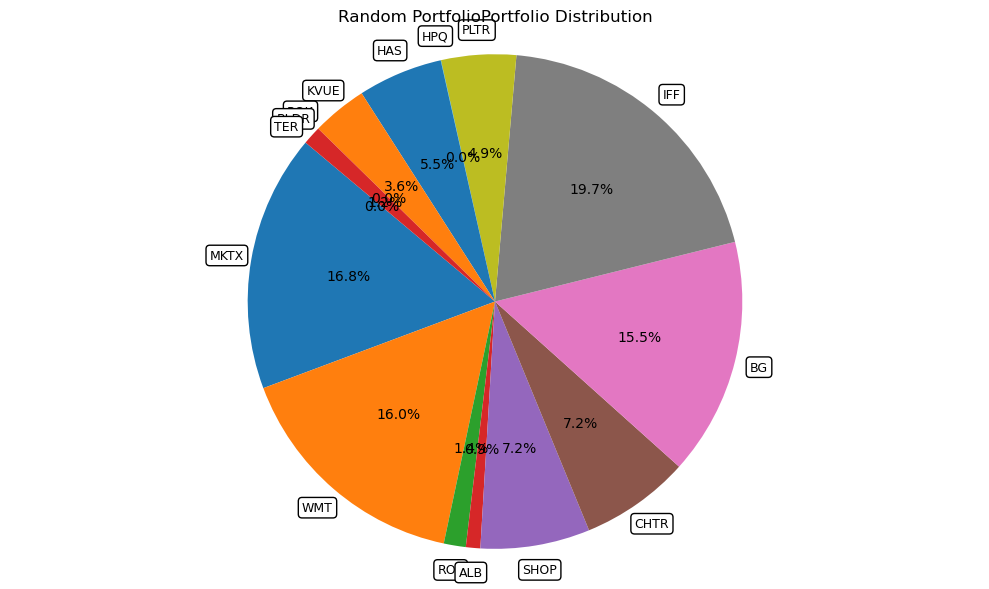

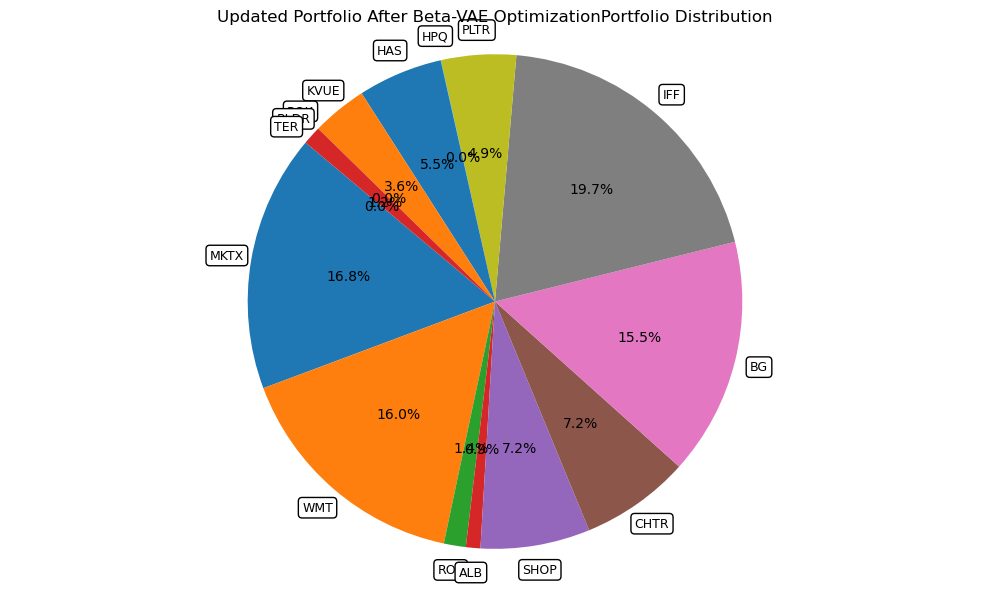

In [23]:
random_portfolio.visualize_portfolio_distribution(pname="Random Portfolio")
updated_portfolio.visualize_portfolio_distribution(pname="Updated Portfolio After Beta-VAE Optimization")

## Implementing the Full Experiment 

In [24]:
# Initialize storage for portfolio results
portfolio_results = []
portfolio_tickers = {}

# Define number of iterations for diversification process
num_portfolios = 15
num_initial_tickers = 15
optim_method = "max_div"

for i in tqdm(range(1, num_portfolios + 1), desc="Beta-VAE Portfolio Diversification..."):
    # Step 1: Generate random portfolio
    random_tickers = np.random.choice(list(all_returns.keys()), num_initial_tickers, replace=False)
    random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}
    random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")
    
    # Optimize initial portfolio
    random_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record initial DR and SR
    initial_dr = random_portfolio.diversification_ratio
    initial_sr = random_portfolio.sharpe_ratio
    
    # Step 2: Generate embeddings
    random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                                   if ticker in stock_embeddings.keys()}
    assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)
    
    # Step 3: Apply diversification function
    updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
        portfolio=random_portfolio,
        portfolio_embeddings=random_portfolio_embeddings,
        all_returns=all_returns,
        all_stock_embeddings=stock_embeddings,
        num_iter=200,
        top_N=5,
        optim_algorithm=optim_method,
        distance_type="euclidean", 
        verbose=False
    )
    
    # Optimize the updated portfolio after swaps
    updated_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record updated DR and SR
    final_dr = updated_portfolio.diversification_ratio
    final_sr = updated_portfolio.sharpe_ratio
    
    # Store tickers for the updated portfolio
    portfolio_tickers[f"Portfolio_{i}"] = updated_portfolio.tickers
    
    # Save results for the dataframe
    portfolio_results.append({
        "Portfolio": f"Portfolio_{i}",
        "Initial_DR": initial_dr,
        "Final_DR": final_dr,
        "DR_Improvement": round(((final_dr - initial_dr)/initial_dr) * 100, 3), # pct improvement
        "Initial_SR": initial_sr,
        "Final_SR": final_sr, 
        "SR_Improvement": round(((final_sr - initial_sr)/initial_sr) * 100, 3), # pct improvement
        "Tickers": updated_portfolio.tickers
    })

# Convert results to a DataFrame
portfolio_results_df = pd.DataFrame(portfolio_results)

# Sort by Final_DR
portfolio_results_df = portfolio_results_df.sort_values(by="DR_Improvement", ascending=False)


Beta-VAE Portfolio Diversification...:   0%|          | 0/15 [00:00<?, ?it/s]

Diversification Iterations: 100%|██████████| 200/200 [00:09<00:00, 21.89it/s]


In [25]:
# Display the table
display(portfolio_results_df)

,Portfolio,Initial_DR,Final_DR,DR_Improvement,Initial_SR,Final_SR,SR_Improvement,Tickers
9,Portfolio_10,2.370881,3.659720,54.361,0.359476,0.142012,-60.495,"[GIS, EW, GPN, RSG, LVS, SYK, AKAM, TAP, FSLR,..."
11,Portfolio_12,2.227655,3.209873,44.092,0.313779,0.323192,3.000,"[BKR, MAR, CF, GIS, NWSA, GPN, MS, JKHY, AZO, ..."
0,Portfolio_1,2.288683,3.268821,42.825,0.199021,0.155746,-21.744,"[ADBE, CARR, ABT, MTB, CZR, INTC, AWK, MSCI, V..."
1,Portfolio_2,2.260791,2.937708,29.942,0.338647,0.288514,-14.804,"[MELI, ZBRA, AMGN, KEYS, CL, WST, JBHT, DOW, T..."
3,Portfolio_4,2.464327,3.077921,24.899,0.105780,0.034985,-66.927,"[WST, PFE, HCA, VST, FITB, BAYRY, AKAM, FSLR, ..."
2,Portfolio_3,2.403350,2.978110,23.915,0.288253,0.238144,-17.384,"[ES, MRK, RSG, AMZN, OXY, VST, FANG, REG, LVS,..."
8,Portfolio_9,2.567284,3.168500,23.418,0.153831,0.247403,60.828,"[PNW, NOC, EOG, DVN, EW, NET, BXP, PFE, OXY, H..."
6,Portfolio_7,2.714609,3.340512,23.057,0.200526,0.192283,-4.111,"[HSY, WBA, MAA, ICE, SQ, NTRS, DVN, HSIC, ORCL..."
7,Portfolio_8,2.658239,3.178226,19.561,0.239234,0.427318,78.620,"[OXY, GRMN, EW, LVS, FSLR, AMZN, HAS, IVZ, AZO..."
12,Portfolio_13,3.060646,3.642080,18.997,0.216065,0.241112,11.592,"[DGX, ALB, GPC, AON, EXC, ADBE, CVX, VMC, BBY,..."


In [26]:
# disply sorted by final SR
display(portfolio_results_df.sort_values(by="SR_Improvement", ascending=False))


,Portfolio,Initial_DR,Final_DR,DR_Improvement,Initial_SR,Final_SR,SR_Improvement,Tickers
7,Portfolio_8,2.658239,3.178226,19.561,0.239234,0.427318,78.620,"[OXY, GRMN, EW, LVS, FSLR, AMZN, HAS, IVZ, AZO..."
8,Portfolio_9,2.567284,3.168500,23.418,0.153831,0.247403,60.828,"[PNW, NOC, EOG, DVN, EW, NET, BXP, PFE, OXY, H..."
12,Portfolio_13,3.060646,3.642080,18.997,0.216065,0.241112,11.592,"[DGX, ALB, GPC, AON, EXC, ADBE, CVX, VMC, BBY,..."
10,Portfolio_11,2.514610,2.690369,6.990,0.348973,0.380397,9.005,"[CSGP, MELI, CB, PAYC, WEC, FCX, MPC, WMB, WFC..."
11,Portfolio_12,2.227655,3.209873,44.092,0.313779,0.323192,3.000,"[BKR, MAR, CF, GIS, NWSA, GPN, MS, JKHY, AZO, ..."
14,Portfolio_15,2.563913,2.705060,5.505,0.263281,0.265901,0.995,"[LHX, ICE, CAG, DXCM, FOX, KR, XYL, WDAY, CDW,..."
6,Portfolio_7,2.714609,3.340512,23.057,0.200526,0.192283,-4.111,"[HSY, WBA, MAA, ICE, SQ, NTRS, DVN, HSIC, ORCL..."
13,Portfolio_14,2.359065,2.689704,14.016,0.321645,0.291751,-9.294,"[COO, AWK, ORLY, IFF, ALB, RF, USB, AEE, SKX, ..."
4,Portfolio_5,2.623184,3.049429,16.249,0.321120,0.277146,-13.694,"[CAH, CEG, PSX, FSLR, AVB, IR, CI, MELI, JNJ, ..."
5,Portfolio_6,2.635059,3.098355,17.582,0.385250,0.332393,-13.720,"[NEE, JKHY, EPAM, AXON, WMB, NWS, CBOE, CB, DI..."
